In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from keras import regularizers
from keras.layers import Dropout, BatchNormalization
import keras_tuner
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# 1. Overview


The following code classifies images from the bird species dataset using a Convolutional Neural Network and aims to optimize accuracy and loss function. The primary goal of image classification is to teach a computer model to recognize patterns, features, and objects within images and assign them to predefined classes or categories—in our case, bird species. Due to limited availability of computational resources, the optimization process has been simplified and the number of classes has been significantly reduced.

In [2]:
train_dir = '/kaggle/input/100-bird-species/train'
test_dir = '/kaggle/input/100-bird-species/test'
valid_dir = '/kaggle/input/100-bird-species/valid'


ImageDataGenerator in Keras is a tool that improves image classification models, including CNNs. It efficiently preprocesses images, manages batches, and seamlessly works with Keras models, enhancing their performance and robustness.

In [3]:
#normalization instances for preprocessing and transform the training images
train_pre = ImageDataGenerator(rescale=1./255)
test_pre = ImageDataGenerator(rescale = 1./255)
valid_pre = ImageDataGenerator(rescale = 1./255)

In [4]:
#Limiting the number of classes to 5
class_list = os.listdir(train_dir)
class_list = class_list[:5]

In [5]:
#the generators contain tuples of x and y where x is the numpy array of images and
#y are the labels. the labels are automatically one hot encoded. 
train_main = train_pre.flow_from_directory(
    train_dir, 
    classes = class_list,
    target_size = (200, 200),
    batch_size = 64,
    class_mode = 'categorical'
)

test_main = test_pre.flow_from_directory(
    test_dir, 
    classes = class_list,
    target_size = (200, 200),
    batch_size = 64,
    class_mode = 'categorical'
)

valid_main = valid_pre.flow_from_directory(
    valid_dir, 
    classes = class_list,
    target_size = (200, 200),
    batch_size = 64,
    class_mode = 'categorical'
)

Found 818 images belonging to 5 classes.
Found 25 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


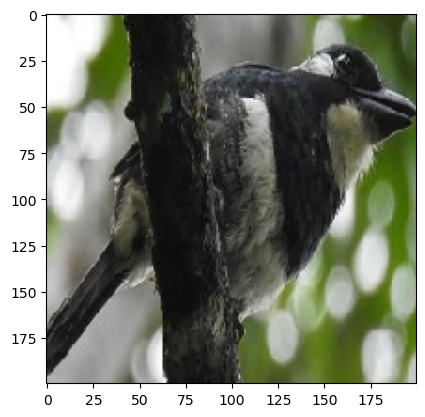

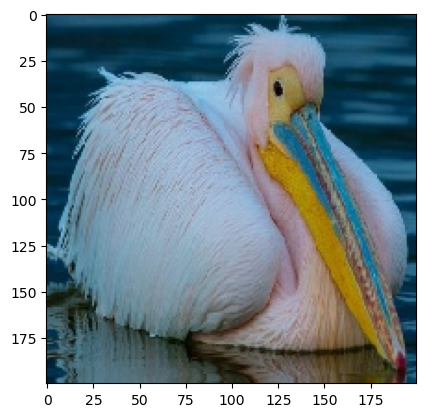

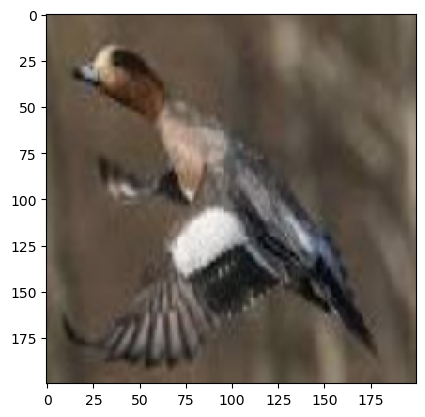

In [6]:
#Display Images
images, labels = next(train_main)

for i in range(3):
    plt.imshow(images[i])
    plt.show()


# Base Model

The function 'eval_model' creates a 'framework' model and trains a Convolutional Neural Network (CNN) for image classification. The CNN consists of several convolutional layers followed by max-pooling layers, flattening, and fully connected layers. It uses ReLU activation functions and l1 regularization if specified. The model is compiled with the Adam optimizer and categorical cross-entropy loss.

In [7]:

#impliment the best values in a new network
initializer = initializers.HeNormal(seed = 20)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizers.l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizers.l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizers.l1(0.0001)))
model.add(Dense(64, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizers.l1(0.0001)))
model.add(Dense(32, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizers.l1(0.0001)))
model.add(Dense(5, activation='softmax', kernel_initializer=initializer))

opt = Adam(learning_rate = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [8]:
# Train the model
history = model.fit(train_main, steps_per_epoch = len(train_main), epochs = 8, validation_data=valid_main)
# Evaluate the model
loss, accuracy = model.evaluate(test_main)
print(f'Test accuracy: {accuracy}')

Epoch 1/8
13/13 [==============================] - 17s 451ms/step - loss: 107.2828 - accuracy: 0.2103 - val_loss: 214101.0625 - val_accuracy: 0.2000
Epoch 2/8
13/13 [==============================] - 2s 136ms/step - loss: 26.5892 - accuracy: 0.2286 - val_loss: 422029.4375 - val_accuracy: 0.2000
Epoch 3/8
13/13 [==============================] - 2s 130ms/step - loss: 26.6387 - accuracy: 0.2286 - val_loss: 362736.7500 - val_accuracy: 0.2000
Epoch 4/8
13/13 [==============================] - 2s 132ms/step - loss: 25.3578 - accuracy: 0.2286 - val_loss: 267832.0625 - val_accuracy: 0.2000
Epoch 5/8
13/13 [==============================] - 2s 141ms/step - loss: 23.9418 - accuracy: 0.2286 - val_loss: 210732.1875 - val_accuracy: 0.2000
Epoch 6/8
13/13 [==============================] - 2s 135ms/step - loss: 22.6397 - accuracy: 0.2286 - val_loss: 174366.0156 - val_accuracy: 0.2000
Epoch 7/8
13/13 [==============================] - 2s 171ms/step - loss: 21.4989 - accuracy: 0.2286 - val_loss: 1529

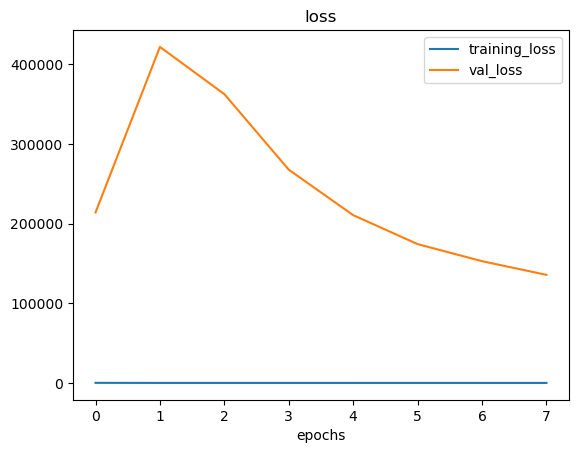

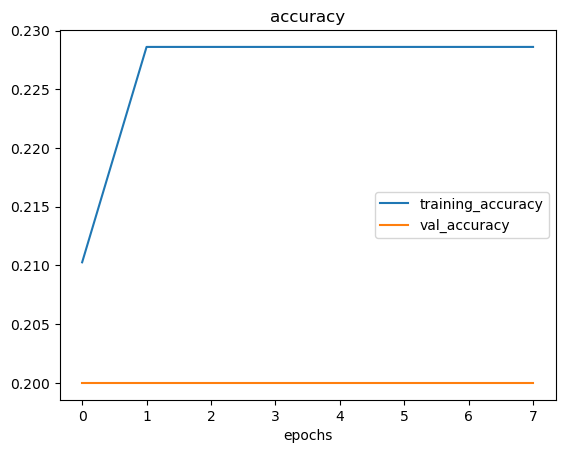

In [9]:
#plot loss and val_accuracy discrepancy
loss = history.history["loss"]
val_loss = history.history["val_loss"]

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(len(history.history["loss"]))

  #plot loss
plt.plot(epochs, loss, label = "training_loss")
plt.plot(epochs, val_loss, label = "val_loss")
plt.title("loss")
plt.xlabel("epochs")
plt.legend()

  #plot accuracy
plt.figure() 
plt.plot(epochs, accuracy, label = "training_accuracy")
plt.plot(epochs, val_accuracy, label = "val_accuracy")
plt.title("accuracy")
plt.xlabel("epochs")
plt.legend()

Even if some iteration of the model performs better than others, the accuracy, in general, is quite low on both the training and validation sets, which  indicates underfitting. Underfitting occurs when a model fails to capture the underlying patterns of the data, resulting in poor performance on both the training and validation data. After all epochs, the model is evaluated on a test set, but achieves an undesirable accuracy. Since the hyperparameters have not been optimized, the performance is quite low. 

# Keras Tuner

Keras Tuner is a Python library that automates the process of searching for the best set of hyperparameters for a neural network models. 

**Tuner will test various node sizes, lr, L and momentum values**

In [10]:

def build_model(hp):
    initializer = initializers.HeNormal(seed=20)
    model = Sequential()    
    regu = hp.Choice('l1_reg', [0.001, 0.0001])
    input_shape=(200, 200, 3)
    
    #Conv layer loop
    for i in range(4):
        nodes = hp.Choice(f'nodes_{i+1}', [32, 64, 128, 256, 512])
        model.add(Conv2D(nodes, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer=initializer, kernel_regularizer=regularizers.l1(regu)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization(momentum=hp.Float('momentum', min_value=0.8, max_value=0.9, step=0.05), epsilon=0.001))
    model.add(Flatten())
    
    #Fully Connected layers
    for i in range(4):
        units = hp.Choice(f'units_{i+1}', [32, 64, 128, 256, 512])
        model.add(Dense(units, activation='relu',kernel_initializer=initializer,kernel_regularizer=regularizers.l1(regu)))
        model.add(BatchNormalization(momentum=hp.Float('momentum', min_value=0.8, max_value=0.95, step=0.05), epsilon=0.001))
     
    model.add(Dense(5, activation='softmax', kernel_initializer=initializer))

    opt = Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0001]))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


Bayesian Optimizer will optimize for the validation loss 

In [11]:
#Using a bayesian optimizer
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective=keras_tuner.Objective("val_loss", direction="min"),
    max_trials=70, 
    num_initial_points=35,  
    overwrite=True  
)
tuner.search(train_main, epochs=5, validation_data=(valid_main))

Trial 70 Complete [00h 00m 20s]
val_loss: 5.61475944519043

Best val_loss So Far: 1.4553202390670776
Total elapsed time: 00h 35m 22s


In [12]:
best_hp = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

# Print the best model summary
best_model = tuner.get_best_models()[0]


Best Hyperparameters:
l1_reg: 0.0001
nodes_1: 32
momentum: 0.8500000000000001
nodes_2: 128
nodes_3: 64
nodes_4: 32
units_1: 32
units_2: 128
units_3: 64
units_4: 32
learning_rate: 0.001


Running a model using the Keras tuner hyperparameters. 

In [13]:

    initializer = initializers.HeNormal(seed=20)
    model1 = Sequential()
    
    for i in range(4):        
    
        model1.add(Conv2D(best_hp.get(f'nodes_{i+1}'), (3, 3), activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l1(best_hp.get('l1_reg'))))
        model1.add(MaxPooling2D(pool_size=(2, 2)))
        model1.add(BatchNormalization(momentum=best_hp.get(f'momentum'), epsilon=0.001))
    
    model1.add(Flatten())
    
    for i in range(4):
        model1.add(Dense(best_hp.get(f'units_{i+1}'),activation='relu',kernel_initializer=initializer,kernel_regularizer=regularizers.l1(best_hp.get('l1_reg'))))
        model1.add(BatchNormalization(momentum=best_hp.get(f'momentum'), epsilon=0.001))
        
    model1.add(Dense(5, activation='softmax', kernel_initializer=initializer))

    opt = Adam(learning_rate=best_hp.get('learning_rate'))
    model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [14]:
fin_hist = model1.fit(train_main, steps_per_epoch = len(train_main), epochs = 8, validation_data=valid_main)
# Evaluate the model
loss, accuracy = model1.evaluate(test_main)
print(f'Test accuracy: {accuracy}')

Epoch 1/8
13/13 [==============================] - 9s 161ms/step - loss: 2.4865 - accuracy: 0.4169 - val_loss: 2.4098 - val_accuracy: 0.4400
Epoch 2/8
13/13 [==============================] - 2s 131ms/step - loss: 1.7739 - accuracy: 0.7359 - val_loss: 1.6273 - val_accuracy: 0.7600
Epoch 3/8
13/13 [==============================] - 2s 126ms/step - loss: 1.4709 - accuracy: 0.8863 - val_loss: 1.4144 - val_accuracy: 0.8400
Epoch 4/8
13/13 [==============================] - 2s 121ms/step - loss: 1.3092 - accuracy: 0.9328 - val_loss: 1.3258 - val_accuracy: 0.8800
Epoch 5/8
13/13 [==============================] - 2s 124ms/step - loss: 1.2180 - accuracy: 0.9597 - val_loss: 1.3271 - val_accuracy: 0.9200
Epoch 6/8
13/13 [==============================] - 2s 129ms/step - loss: 1.1770 - accuracy: 0.9719 - val_loss: 1.2744 - val_accuracy: 0.9200
Epoch 7/8
13/13 [==============================] - 2s 131ms/step - loss: 1.1198 - accuracy: 0.9890 - val_loss: 1.2701 - val_accuracy: 0.9200
Epoch 8/8
1/1

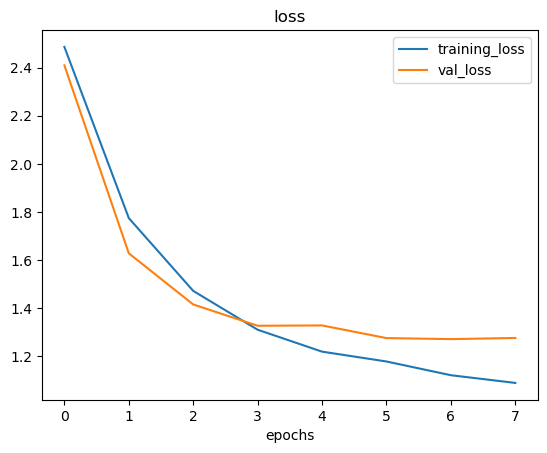

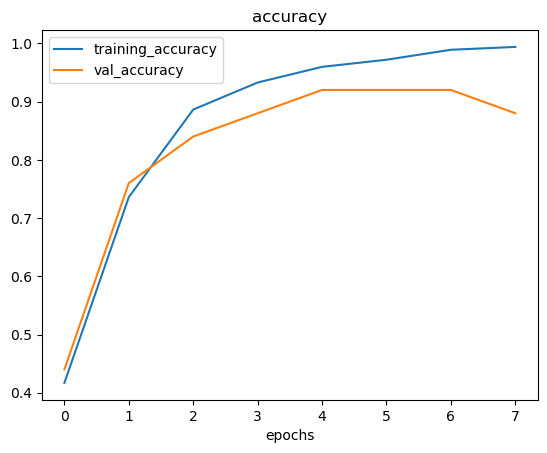

In [15]:
loss = fin_hist.history["loss"]
val_loss = fin_hist.history["val_loss"]

accuracy = fin_hist.history["accuracy"]
val_accuracy = fin_hist.history["val_accuracy"]
epochs = range(len(fin_hist.history["loss"]))

  #plot loss
plt.plot(epochs, loss, label = "training_loss")
plt.plot(epochs, val_loss, label = "val_loss")
plt.title("loss")
plt.xlabel("epochs")
plt.legend()

  #plot accuracy
plt.figure() 
plt.plot(epochs, accuracy, label = "training_accuracy")
plt.plot(epochs, val_accuracy, label = "val_accuracy")
plt.title("accuracy")
plt.xlabel("epochs")
plt.legend()

As shown by both the graphs and the training logs, the optimized model is significantly more accurate on the test data set and is able to achieve a lower validation loss. Since the validation accuracy is high, it is generalizing well to unseen data. 